In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from scipy.stats import norm, sem
from scipy.interpolate import UnivariateSpline
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.stats import pearsonr
from numpy.random import default_rng
import random
pd.set_option('display.max_columns', 100)

In [24]:
from metalearner import * 

In [2]:
df = pd.read_csv('GerberGreenLarimer_APSR_2008_social_pressure.csv')
df = df[df['treatment'].isin([' Control',' Neighbors'])]

In [3]:
# df = pd.read_csv('GerberGreenLarimer_APSR_2008_social_pressure.csv')
df['treatment'] = np.where(df.treatment == ' Control',0,1)
df['voted'] = np.where(df.voted == 'Yes', 1, 0)
df['sex'] = np.where(df.sex == 'male',1, 0)
df['g2000'] = np.where(df.g2000 == 'yes', 1, 0)
df['g2002'] = np.where(df.g2002 == 'yes', 1, 0)
df['g2004'] = np.where(df.g2004 == 'yes', 1, 0)
df['p2000'] = np.where(df.p2000 == 'yes', 1, 0)
df['p2002'] = np.where(df.p2002 == 'yes', 1, 0)
df['p2004'] = np.where(df.p2004 == 'Yes', 1, 0)

In [4]:
cts_variables_names = ["yob","treatment","cluster","hh_id","hh_size","numberofnames","p2004_mean","g2004_mean"]
binary_variables_names = ["sex","g2000", "g2002", "p2000", "p2002", "p2004"]
# for column in binary_variables_names:
#     if column == 'sex':
#         df[column] = np.where(df[column] == ' male',1,0)
#     else:
#         df[column] = df[column].str.lower()
#         df[column] = np.where(df[column] == ' yes',1,0)
scaled_cts_covariates = StandardScaler().fit_transform(df[cts_variables_names])
binary_covariates = df[binary_variables_names]
d = pd.DataFrame(np.concatenate((scaled_cts_covariates, binary_covariates), axis=1), 
                        columns=cts_variables_names+binary_variables_names, index=df.index)
d["W"] = df["treatment"]
d["Y"] = df["voted"]

In [7]:
# we need to change Y from binary to numeric, where numeric is the probability of being 1
# so eg: for i with w = 0, we will have prob(yi = 1 | xi) as y0, prob(yi = 1 | xi) + r(x) as y1

def T_learner(d):
    # w == 0
    d0 = d[d['W'] == 0]
    X_d0 = d0.drop(columns=['W','Y'])
    y_d0 = d0['Y']
    clf_d0 = RandomForestClassifier()
    clf_d0.fit(X_d0,y_d0)

    # w == 1
    d1 = d[d['W'] == 1]
    X_d1 = d1.drop(columns=['W','Y'])
    y_d1 = d1['Y']
    clf_d1 = RandomForestClassifier()
    clf_d1.fit(X_d1,y_d1)

    pred_y0 = clf_d0.predict_proba(d.drop(columns= ['W','Y']))[:,1]
    pred_y1 = clf_d1.predict_proba(d.drop(columns= ['W','Y']))[:,1]
    
    ate_score = (sum(pred_y1) - sum(pred_y0)) / len(pred_y0)
    return ate_score, clf_d0, clf_d1

In [12]:
rx, clf_d0, clf_d1 = T_learner(d)
pred_y0 = clf_d0.predict_proba(d.drop(columns= ['W','Y']))[:,1]
pred_y1 = clf_d1.predict_proba(d.drop(columns= ['W','Y']))[:,1]

In [15]:
# replace binary labels by probs 
new_y0 = []
new_y1 = []
Y = []
for i in range(len(d)):
    if d.iloc[i].W == 0.0:
        Y.append(pred_y0[i])
        new_y0.append(pred_y0[i])
        new_y1.append(pred_y0[i] + rx)
    else:
        Y.append(pred_y1[i])
        new_y0.append(pred_y1[i] - rx)
        new_y1.append(pred_y1[i])

d['new_y0'] = new_y0
d['new_y1'] = new_y1
d['Y'] = Y

In [ ]:
d

In [21]:
def get_samples(data, control_treat_prop, n_training_set = 50000, n_testing_set = 2000):
    
    # randomly select 50000 training set and 2000 testing set
    # among them, we need to make w = 1 and w = 0 according to proportion, this is the permutation we have
    idx = list(np.arange(len(data)))
    random_idx = random.sample(idx, n_training_set + n_testing_set)
    # frist 50000 are training, last 2000 are testing
    train_sample = random_idx[:n_training_set]
    test_sample = random_idx[n_training_set:]
    train_df = data.iloc[train_sample].copy()
    test_df = data.iloc[test_sample].copy()
    
    # assgin w = 1 according to proprtion
    w_train = np.zeros(len(train_sample))
    w_train[int(len(train_sample) * control_treat_prop) :] = 1 
    w_test = np.zeros(len(test_sample))
    w_test[int(len(test_sample) * control_treat_prop) :] = 1 
    
    # choose new Y
    y_train = []
    y_test = []
    for i in range(len(w_train)):
        if w_train[i] == 0:
            y_train.append(train_df.iloc[i].new_y0)
        else:
            y_train.append(train_df.iloc[i].new_y1)
    for i in range(len(w_test)):
        if w_test[i] == 0:
            y_test.append(test_df.iloc[i].new_y0)
        else:
            y_test.append(test_df.iloc[i].new_y1)
    # add new W,Y to both dfs respectively
    train_df = train_df.drop(columns = ['W','Y','new_y0','new_y1'])
    test_df = test_df.drop(columns = ['W','Y','new_y0','new_y1'])
    train_df['W'] = w_train
    train_df['Y'] = y_train
    test_df['W'] = w_test
    test_df['Y'] = y_test
    
    return train_df, test_df


In [ ]:
s_df, t_df, x_df = boostrap_exp(d, len(d[d['W'] == 1])/len(d[d['W'] == 0]), rx )

In [36]:
s_df['estimator'] = ['S_learner']
x_df['estimator'] = ['X_learner']

In [129]:
def get_bootstrap_coverage_CIlength(all_estimates,real_ate, learner_name,  alpha=0.05):
    '''
    params: all_estiamtes: np.matrix, size = (n_models, n_testset)
    real_ate: real ate
    learner_name: meta-learner name 
    '''

    est_stat = []
    signif_level = -norm.ppf(alpha/2)
    ci_lengths = []
    if_covers = 0
    print(learner_name)
    for col in range(all_estimates.shape[1]):
        point_ites = all_estimates[:,col]
        std = np.std(point_ites)
        mean_ite = np.mean(point_ites)
        ci_lengths += [2 * (signif_level * std)]
        if real_ate < (signif_level * std) + mean_ite and real_ate >   mean_ite - (signif_level * std):
            print(real_ate)
            print((signif_level * std) + mean_ite)
            print(mean_ite - (signif_level * std))
            if_covers += 1
    stat = {}
    stat['estimator'] = learner_name
    stat['coverage'] = if_covers / all_estimates.shape[1]
    stat['average_interval_length'] = np.mean(ci_lengths)
    
    return pd.DataFrame([stat])

In [134]:
def boostrap_exp_test_point(data,control_treat_prop,full_ate,  n_training_set = 50000, n_testing_set = 2000):
        Slearner_bool_ates = []
        Xlearner_bool_ates = []
        Tlearner_bool_ates = []
        full_estimate_ate = full_ate
        # only get one test_df
        print('1111')
        _, test_df = get_samples(data,control_treat_prop)
        for time in range(2):
            print(time, ' Finished')
            t_learner = Tlearner(RandomForestRegressor(),RandomForestRegressor(),is_regressor= True)
            s_learner = Slearner(RandomForestRegressor(), is_regressor= True)
            x_learner = Xlearner(RandomForestRegressor(), propensity_model = LogisticRegression(), is_regressor= True)
            train_df, _ = get_samples(data,control_treat_prop)
            # train T S X learner 
            t_learner.fit(train_df.drop(columns = ['W','Y']), train_df['W'], train_df['Y'])
            s_learner.fit(train_df.drop(columns = ['W','Y']), train_df['W'], train_df['Y'])
            x_learner.fit(train_df.drop(columns = ['W','Y']), train_df['W'], train_df['Y'])
            # calculate the ites for all test points 
            s_ite, _, _, _ = s_learner.get_ite(test_df.drop(columns = ['W','Y']), test_df['W'], test_df['Y'])
            x_ite, _, _, _ = x_learner.get_ite(test_df.drop(columns = ['W','Y']), test_df['W'], test_df['Y'])
            t_ite, _, _, _ = t_learner.get_ite(test_df.drop(columns = ['W','Y']), test_df['W'], test_df['Y'])
            Slearner_bool_ates.append(s_ite)
            Xlearner_bool_ates.append(x_ite)
            Tlearner_bool_ates.append(t_ite)
            
        s_result = get_bootstrap_coverage_CIlength(np.array(Slearner_bool_ates), full_estimate_ate,'Slearner',  alpha=0.05)
        t_result = get_bootstrap_coverage_CIlength(np.array(Tlearner_bool_ates), full_estimate_ate,'Tlearner',  alpha=0.05)
        x_result = get_bootstrap_coverage_CIlength(np.array(Xlearner_bool_ates), full_estimate_ate,'Xlearner',  alpha=0.05)
        
        return s_result, t_result, x_result
            


In [ ]:
s_result, t_result, x_result = boostrap_exp_test_point(d, len(d[d['W'] == 1])/len(d[d['W'] == 0]), rx )

In [132]:
all_result = pd.concat([s_result,t_result,x_result])

In [133]:
all_result

,estimator,coverage,average_interval_length
0,Slearner,0.0,0.0
0,Tlearner,0.0,0.0
0,Xlearner,0.0,0.0


In [122]:
all_result

,estimator,coverage,average_interval_length
0,Slearner,1.0,0.461823
0,Tlearner,1.0,0.554007
0,Xlearner,1.0,0.292478


In [123]:
coverage = all_result['coverage']
average_interval_length = all_result['average_interval_length']
names = all_result['estimator']

In [124]:
average_interval_length

0    0.461823
0    0.554007
0    0.292478
Name: average_interval_length, dtype: float64

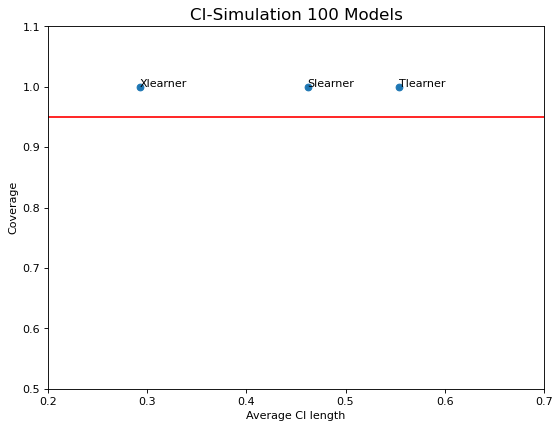

In [125]:
%matplotlib inline
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)


plt.scatter(average_interval_length,coverage)
plt.xlim(0.2,0.7)
plt.ylim(0.5,1.1)
plt.axhline(y=0.95, color='r', linestyle='-')

plt.xlabel("Average CI length")
plt.ylabel("Coverage")
plt.title("CI-Simulation 100 Models",fontsize=15)
annotations = all_result['estimator']
for i, label in enumerate(annotations):
    plt.annotate(label, (average_interval_length.iloc[i], coverage.iloc[i]))


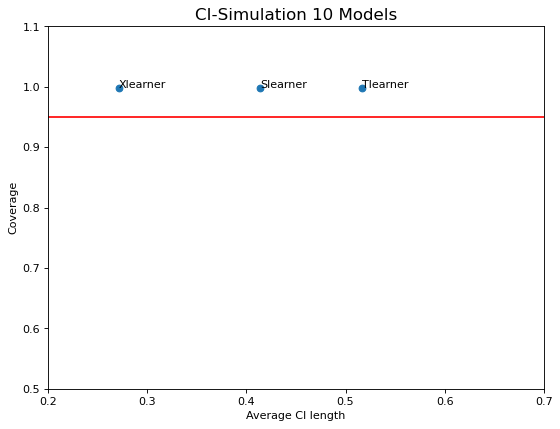

In [115]:
%matplotlib inline
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)


plt.scatter(average_interval_length,coverage)
plt.xlim(0.2,0.7)
plt.ylim(0.5,1.1)
plt.axhline(y=0.95, color='r', linestyle='-')

plt.xlabel("Average CI length")
plt.ylabel("Coverage")
plt.title("CI-Simulation 10 Models",fontsize=15)
annotations = all_result['estimator']
for i, label in enumerate(annotations):
    plt.annotate(label, (average_interval_length.iloc[i], coverage.iloc[i]))
